In [9]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import data
import pandas as pd

In [10]:
# Drop same or zero columns
X_train,y_train,X_test = data.load_data()
same_columns = []
for i in range(0,595):
    if i not in same_columns:
        counter = i + 1
        while counter < 595:
            if X_train.iloc[:,i].equals(X_train.iloc[:,counter]):
                same_columns.append(counter)
            counter += 1

In [12]:
X_train,y_train,X_test = data.load_data()
same_columns.append(2)
same_columns = list(set(same_columns))
for i in same_columns:
    X_train.drop(columns='X'+str(i+1), axis=1, inplace=True)
    X_test.drop(columns='X'+str(i+1), axis=1, inplace=True)

1.0


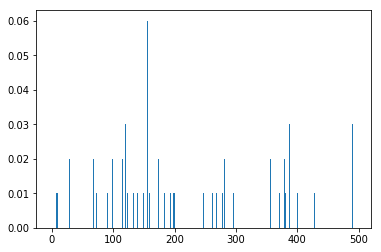

'\nlsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)\nmodel = SelectFromModel(lsvc, prefit=True)\nX_new = model.transform(X)\nX_new.shape\n'

In [13]:
# fit model no training data
#model = DecisionTreeClassifier()
model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_pred, y_train)
print(accuracy)
# feature importance
features_importance = model.feature_importances_
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()
"""
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
"""

In [31]:
X_train,y_train,X_test = data.load_data()
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.001)
selector.fit(X_train)
train_instances = selector.transform(X_train)
test_instances = selector.transform(X_test)

In [32]:
train_instances.shape

(120, 393)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, train_instances, y_train, cv=5)
print(scores.mean())
clf.fit(train_instances, y_train)
data.write_output(clf.predict(test_instances).reshape(-1,1))

0.4833333333333333


In [34]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
estimator = SVC(kernel="linear")
selector = RFECV(estimator, step=1, cv=4)
clf = GridSearchCV(selector, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
clf.best_estimator_.estimator_
clf.best_estimator_.grid_scores_
clf.best_estimator_.ranking_


ValueError: Invalid parameter C for estimator RFECV(cv=4,
   estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [35]:
# Select from model

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train)
#embeded_lr_selector = SelectFromModel(LogisticRegression(), '1.25*median')
embeded_lr_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), '1.25*median')
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

236 selected features


In [36]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000))
embeded_lgb_selector.fit(train_instances, y_train)

AdaBoostClassifier()


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [37]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

145 selected features


In [44]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=5), max_features=250)),
  ('reduce_dim', PCA()),
  ('classification', SVC(kernel="linear", C=0.01))
])
scores = cross_val_score(clf, train_instances, y_train, cv=5)
scores.mean()

0.525

In [43]:
clf.fit(train_instances, y_train)
data.write_output(clf.predict(test_instances).reshape(-1,1))

In [47]:
import numpy as np
from scipy.stats import uniform as sp_rand
from sklearn import datasets
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV

embeded_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=5))
embeded_selector.fit(X_train, y_train)
embeded_support = embeded_selector.get_support()
embeded_feature = X_train.loc[:,embeded_support].columns.tolist()

# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = RidgeClassifier()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_train.loc[:,embeded_feature], y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f91a6c67ef0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
0.5916666666666667
0.1862871889591372


In [180]:

y_pred = rsearch.predict(X_test.loc[:,embeded_feature])
data.write_output(y_pred.reshape(-1,1))

In [188]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': list(range(10,150,5)), 'lr__C': np.logspace(-10, 10, 5)})
grid_search.fit(X_train, y_train)
grid_search.best_score_

0.5416666666666666

In [189]:
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()  
X_train = feature_scaler.fit_transform(X_train)  
X_test = feature_scaler.transform(X_test)  

In [190]:
X_train

array([[-0.39040846, -0.06301876,  0.        , ...,  0.44130392,
         0.45562567,  0.90504614],
       [ 0.39849978, -0.64014634,  0.        , ..., -0.58391828,
         0.28964609, -0.7856502 ],
       [ 0.62327069,  0.44002423,  0.        , ...,  1.2475573 ,
         0.74891957,  0.77388759],
       ...,
       [ 0.27897484, -0.47018629,  0.        , ...,  0.09129709,
         1.70455108,  0.90370892],
       [-0.07383771, -1.43926882,  0.        , ..., -0.27689818,
        -0.07597727,  0.11161547],
       [ 1.18480449,  0.67705052,  0.        , ..., -0.33156886,
         0.95208082, -0.72387582]])

In [193]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
GridSearchCV(scoring="accuracy",cv=k_fold)

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_grid'

In [210]:
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', 'passthrough'),
    ('classify', SVC())
])

N_FEATURES_OPTIONS = list(range(10,90,10))
C_OPTIONS = [1, 10, 100, 1000]
c = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        
        'C': c,
        'kernel': ['linear']},
    {
        'C': c,
        'gamma': [0.001, 0.0001],
        'kernel': ['rbf']},
]


grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, scoring="accuracy",cv=k_fold)
grid.fit(X_train,y_train )

reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

Automatically created module for IPython interactive environment


ValueError: Invalid parameter C for estimator Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [209]:
grid.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [234]:

class ModelTransformer(TransformerMixin):

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return DataFrame(self.model.predict(X))
    
pipeline = Pipeline([
    
    ('estimators', FeatureUnion([
        ('knn', ModelTransformer(KNeighborsRegressor(n_neighbors=5))),
        ('gbr', ModelTransformer(GradientBoostingRegressor())),
        ('dtr', ModelTransformer(DecisionTreeRegressor())),
        ('etr', ModelTransformer(ExtraTreesRegressor())),
        ('rfr', ModelTransformer(RandomForestRegressor())),
        ('par', ModelTransformer(PassiveAggressiveRegressor())),
        ('en', ModelTransformer(ElasticNet())),
        ('cluster', ModelTransformer(KMeans(n_clusters=2)))
    ])),
    ('estimator', KNeighborsRegressor())
])


NameError: name 'TransformerMixin' is not defined

In [237]:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("selct", SelectFromModel(RandomForestClassifier())), ("univ_select", selection)])

In [238]:
combined_features.fit(X_train,y_train).transform(X_train)
combined_features.get_feature_names()

AttributeError: Transformer selct (type SelectFromModel) does not provide get_feature_names.

In [222]:
combined_features = FeatureUnion([("pca", ModelTransformer(DecisionTreeRegressor())), ("univ_select", ModelTransformer(RandomForestClassifier()))])

NameError: name 'ModelTransformer' is not defined